In [56]:
import pandas as pd
import numpy as np
import datetime
import praw
from collections import Counter
import string

import requests
import requests.auth
import pandas as pd
import time
import json
import time
import boto3
import ast

import re

import nltk
nltk.download('stopwords')
nltk.download('names')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import names
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.models import HdpModel
from gensim.utils import lemmatize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading in the data

Note on below: I downloaded the data.txt file from the S3 bucket using the credentials that Sanjeev emailed out. I saved the data.txt file in a different folder, not the one that this notebook is in. I don't want to be pushing and pulling 47k stories to github.

Also, if Jupyter notebook gives you some rate limit issue opening the file in here (it did for me), you can fix that by following the directions in this link: https://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-in-jupyter-notebook-when-viewing-image

In [29]:
d = {"author": [], "author_fullname": [], "full_link": [], "id": [], "score": [], "selftext": [], "title": [], "sortKey": []}
with open("../nosleep-data/data.txt") as f:
        for line in f:
            line = ast.literal_eval(line)
            d["author"].append(line["author"])
            d["author_fullname"].append(line["author_fullname"])
            d["full_link"].append(line["full_link"])
            d["id"].append(line["id"])
            d["score"].append(line["score"])
            d["selftext"].append(line["selftext"])
            d["title"].append(line["title"])
            d["sortKey"].append(line["sortKey"])

In [30]:
story_df = pd.DataFrame(data=d)
story_df.head()

,author,author_fullname,full_link,id,score,selftext,title,sortKey
0,GloriousWilliam666,t2_2uxklusg,https://www.reddit.com/r/nosleep/comments/abf5...,abf59b,1,It was 10:30 of new years night. I was sitting...,New Year's Demon,1546491600
1,Offic3r_Friendly,t2_2ukwz8im,https://www.reddit.com/r/nosleep/comments/abf8...,abf8by,1,\n\nI've worked in security for approximately...,It lives underneath the Campus,1546491600
2,iamanovelty,t2_h4aqm,https://www.reddit.com/r/nosleep/comments/abfa...,abfav7,1,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,1546491600
3,John_Drinks,t2_2vo97ouc,https://www.reddit.com/r/nosleep/comments/abfb...,abfbj9,1,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,1546491600
4,claire_e_albers,t2_2k4wz7bm,https://www.reddit.com/r/nosleep/comments/abfk...,abfk8f,1,The women howled with laughter as they finishe...,Eyes On the Road,1546491600


In [31]:
story_df.shape

(47125, 8)

In [32]:
story_df = story_df.drop(columns = ['author_fullname','full_link','id','score','sortKey'])
story_df.head()

,author,selftext,title
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road


# Data Cleaning

In [35]:
# remove punctuation
story_df['processed'] = story_df['selftext'].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
story_df.head()

,author,selftext,title,processed
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon,It was 1030 of new years night I was sitting o...
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus,\n\nIve worked in security for approximately ...
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,I decided to start petsitting again\n\nThis st...
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,\n\nSince the passing of my wife I have been...
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road,The women howled with laughter as they finishe...


In [36]:
# make it all lower case
story_df['processed'] = story_df['processed'].map(lambda x: x.lower())
story_df.head()

,author,selftext,title,processed
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon,it was 1030 of new years night i was sitting o...
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus,\n\nive worked in security for approximately ...
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,i decided to start petsitting again\n\nthis st...
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,\n\nsince the passing of my wife i have been...
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road,the women howled with laughter as they finishe...


In [37]:
# remove stop words and names

combined_stops = names.words('male.txt')
combined_stops.extend(stopwords.words('english'))
combined_stops.extend(names.words('female.txt'))
combined_stops = set(combined_stops)

story_df['processed'] = story_df['processed'].map(lambda x: ' '.join(y for y in x.split() if y not in combined_stops))
story_df.head()

,author,selftext,title,processed
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon,1030 new years night sitting couch watching ne...
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus,ive worked security approximately 6 years work...
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,decided start petsitting story isn’t cujo migh...
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,since passing wife living quaint sizable seclu...
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road,women howled laughter finished second bottle w...


In [46]:
# helper function for lemmatizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [64]:
# stem the words
stemmer = PorterStemmer() 
story_df['processed'] = story_df['processed'].map(lambda x: [stemmer.stem(y) for y in x.split()])
story_df.head()

,author,selftext,title,processed
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon,"[1030, new, year, night, sit, couch, watch, ne..."
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus,"[ive, work, secur, approxim, 6, year, work, ma..."
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,"[decid, start, petsit, stori, isn’t, cujo, mig..."
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,"[sinc, pass, wife, live, quaint, sizabl, seclu..."
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road,"[women, howl, laughter, finish, second, bottl,..."


In [65]:
# removing numbers
story_df['processed'] = story_df['processed'].map(lambda x: [item for item in x if not item.isdigit()])
story_df.head()

,author,selftext,title,processed
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon,"[new, year, night, sit, couch, watch, news, wa..."
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus,"[ive, work, secur, approxim, year, work, mani,..."
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,"[decid, start, petsit, stori, isn’t, cujo, mig..."
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,"[sinc, pass, wife, live, quaint, sizabl, seclu..."
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road,"[women, howl, laughter, finish, second, bottl,..."


In [73]:
# export cleaned dataframe to an excel doc
#outp_file.write(story_df.to_csv().encode('utf-8', 'replace').decode('utf-8'))

NameError: name 'outp_file' is not defined

# Trying HDP-LDA using the Gensim library

In [74]:
# Create Dictionary
id2word = corpora.Dictionary(story_df['processed'])

# Create Corpus
texts = story_df['processed']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [75]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [76]:
hdptopics = hdpmodel.show_topics(formatted=False)

In [90]:
def topic_prob_extractor(gensim_hdp, t=-1, w=25, isSorted=True):
    """
    Input the gensim model to get the rough topics' probabilities
    """
    shown_topics = gensim_hdp.show_topics(num_topics=t, num_words=w ,formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]
    if (isSorted):
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights}).sort_values(by = "weight", ascending=False);
    else:
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights});

In [93]:
topics = topic_prob_extractor(hdpmodel)
topics.head()

,topic_id,weight
5,5,0.186276
17,17,0.145884
20,20,0.144317
4,4,0.140664
7,7,0.133823


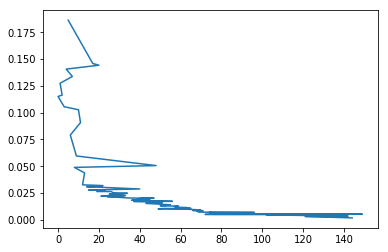

In [94]:
plt.plot(rangetopics['weight'])
plt.show()

# Non-negative Matrix Factorization

This method should be disregarded. It takes way too long to run and it's really hard to determine the "right" amount of topics to use. I'm leaving it in here for when we have to write our progress report.

In [10]:
# Make a TF-IDF
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=None, decode_error="replace")
doc_term_matrix = tfidf_vect.fit_transform(story_df['processed'].values)

In [11]:
# Need to tune n_components
errors = []
for i in range(5,100,10):
    print(i)
    nmf = NMF(n_components=i, random_state=42)
    nmf = nmf.fit(doc_term_matrix )
    errors.append(nmf.reconstruction_err_)

5
15
25
35
45
55
65
75
85
95


In [12]:
errors

[185.39558501413458,
 183.25519852563295,
 181.95236838123353,
 180.85081104827208,
 179.8827149141605,
 179.05851195493125,
 178.23408061388184,
 177.40889349999222,
 176.71209153499058,
 176.0112027145298]

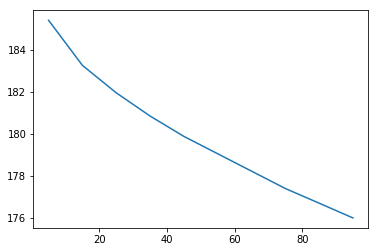

In [13]:
plt.plot(range(5,100,10),errors)
plt.show()

# Appendix

In [ ]:
my_subreddit = subreddit.new(limit=1)
for submission in my_subreddit:
    print(submission.title)
    print('     ')
    all_comments = submission.comments.list()
    for comment in all_comments:
        #print(vars(comment))
        print(comment.body)
        print(comment.author)
        print(comment.likes)
        print('-------')

For the below, follow the directions here https://www.storybench.org/how-to-scrape-reddit-with-python/

In [ ]:
PERSONAL_USE_SCRIPT_14_CHARS = 'you_personal_use_script'
SECRET_KEY_27_CHARS = 'your_secret_key'
YOUR_APP_NAME = 'your_app_name'
YOUR_REDDIT_USER_NAME = 'your_reddit_name'
YOUR_REDDIT_LOGIN_PASSWORD = 'your_password'

In [ ]:
reddit = praw.Reddit(client_id=PERSONAL_USE_SCRIPT_14_CHARS,
                     client_secret=SECRET_KEY_27_CHARS,
                     password=YOUR_REDDIT_LOGIN_PASSWORD,
                     user_agent=YOUR_APP_NAME,
                     username=YOUR_REDDIT_USER_NAME)

In [ ]:
print(reddit.user.me())

In [ ]:
subreddit = reddit.subreddit('nosleep')

In [ ]:
stories_dict = {"story_id": [],
                "title": [],
               "author": [],
               "body": []}

In [ ]:
'''
comments_dict = {"story_id":[],
                "comment_author": [],
                "comment_body": []}
'''

In [ ]:
my_subreddit = subreddit.hot(limit=500)
for submission in my_subreddit:
    stories_dict["title"].append(submission.title)
    stories_dict["body"].append(submission.selftext)
    stories_dict["author"].append(submission.author)
    stories_dict["story_id"].append(submission.id)
    all_comments = submission.comments.list()
    '''
    for comment in all_comments:
        comments_dict["story_id"].append(submission.id)
        comments_dict["comment_body"].append(comment.body)
        comments_dict["comment_author"].append(comment.author)
    '''

In [ ]:
story_df = pd.DataFrame(stories_dict)
story_df.head()

In [ ]:
story_df = story_df.drop([0, 1], )
story_df.head()

In [ ]:
story_df.shape

In [ ]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

In [ ]:
scores = []
for i in range(2,50):
    km = KMeans(n_clusters=i).fit(X)
    labels = km.labels_
    score = silhouette_score(X, labels, metric='cosine')
    scores.append(score)

In [ ]:
plt.plot(range(2,50),scores)
plt.show()

# Comment Analysis

In [ ]:
my_subreddit = subreddit.new(limit=1)
for submission in my_subreddit:
    print(submission.title)
    print('     ')
    all_comments = submission.comments.list()
    for comment in all_comments:
        #print(vars(comment))
        print(comment.body)
        print(comment.author)
        print(comment.likes)
        print('-------')